# MMOB Project

# import

in this cell, relevant libraries are imported, as well as the datafile imported from our github and a dict that will store all results during the project 

In [5]:
import pandas as pd
import numpy as np
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable, Derive
from biogeme import models
from biogeme import results as res
from biogeme.expressions import DefineVariable, log
data_file ='https://raw.githubusercontent.com/DunodMax/MMOB/main/Dataset.txt'
LPMC = pd.read_csv(data_file, sep='\t')
LPMC
database = db.Database('LPMC', LPMC)
all_results = {}
from collections import namedtuple

In [6]:
LPMC.head()

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent
0,18,4,0,0,3,3,6,5,0.0,1,...,0.171389,0.0,0.334444,0.0,0,0.196389,0.0,0.53,0.0,0.035361
1,20,5,1,0,4,3,1,5,0.0,1,...,0.381667,0.0,0.062222,0.0,0,0.117222,0.0,0.41,0.0,0.097156
2,21,5,1,1,4,3,1,5,0.0,1,...,0.083889,0.0,0.293611,0.0,0,0.167778,0.0,0.46,0.0,0.243377
3,22,6,0,0,3,3,6,1,1.0,1,...,0.109167,0.0,0.133333,0.0,0,0.093889,1.5,0.23,0.0,0.204142
4,31,8,1,5,1,3,1,1,1.0,1,...,0.101111,0.0,0.038056,0.0,0,0.055000,1.5,0.14,0.0,0.075758


# Model 0

Creation of a new Header in data to simplify future calculation with derivatives ( it is beter to have one variable for "dur_pt")

In [7]:
LPMC["dur_pt"]= LPMC["dur_pt_access"] + LPMC["dur_pt_rail"] + LPMC["dur_pt_bus"] + LPMC["dur_pt_int"] 
LPMC["cost_drive"] = LPMC["cost_driving_ccharge"] + LPMC["cost_driving_fuel"]

all useful columns for this model are used as variables

In [8]:
travel_mode=Variable('travel_mode')

dur_pt_access=Variable('dur_pt_access')
dur_pt_rail=Variable('dur_pt_rail')
dur_pt_bus=Variable('dur_pt_bus')
dur_pt_int=Variable('dur_pt_int')


pt_interchanges=Variable('pt_interchanges')
dur_driving=Variable('dur_driving')
cost_transit=Variable('cost_transit')

cost_driving_fuel=Variable('cost_driving_fuel')
cost_driving_ccharge=Variable('cost_driving_ccharge')

dur_walking=Variable('dur_walking')
dur_cycling=Variable('dur_cycling')

female=Variable('female')
age=Variable('age')

Trip duration for each mode are computed ( see report for details about equations)
Cost for each mode with a cost are computed ( cycling and walking is considered free)

In [9]:
time_walk=dur_walking
time_cycle=dur_cycling
time_pt=Variable('dur_pt')
time_drive=dur_driving

cost_drive=Variable('cost_drive')
cost_pt=cost_transit

There is 4 different travel mode, we will thus build a model with 4 utility functions, we create 3 alternative specific constant, a generic parameter for travel time and a generic parameter for cost

In [10]:
asc_cycle = Beta('asc_cycle', 0, None, None, 0)
asc_pt = Beta('asc_pt', 0, None, None, 0)
asc_drive = Beta('asc_drive', 0, None, None, 0)
beta_cost = Beta('beta_cost', 0, None, None, 0)
beta_time = Beta('beta_time', 0, None, None, 0)

utility functions

In [11]:
v_walk_model0= beta_time * time_walk  
v_cycle_model0= asc_cycle + beta_time * time_cycle 
v_pt_model0= asc_pt + beta_time * time_pt + beta_cost * cost_pt
v_drive_model0= asc_drive + beta_time * time_drive + beta_cost * cost_drive

In [12]:
av = {1: 1, 2: 1, 3: 1, 4:1}

estimation of the parameters for Model 0, all relevant parameters are printed

In [13]:
V_model0 = {1: v_walk_model0 , 2: v_cycle_model0, 3: v_pt_model0, 4: v_drive_model0}
logprob_model0 = models.loglogit(V_model0, av, travel_mode)
biogeme_model0 = bio.BIOGEME(database, logprob_model0)
biogeme_model0.modelName = 'Model_0'
all_results['Model0'] = biogeme_model0.estimate()
results_generic = biogeme_model0.estimate()
results_generic.getEstimatedParameters()

[14:55:38] < Warning >   Cannot read file __Model_0.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycle,-3.832163,0.107574,-35.623351,0.0
asc_drive,-1.235707,0.080400,-15.369411,0.0
asc_pt,-0.528767,0.054766,-9.655006,0.0
beta_cost,-0.169780,0.013108,-12.952753,0.0
beta_time,-5.450540,0.202684,-26.891767,0.0


In [14]:
res.compileEstimationResults(all_results)

,Model0
Number of estimated parameters,5.000000
Sample size,5000.000000
Final log likelihood,-4566.446492
Akaike Information Criterion,9142.892983
Bayesian Information Criterion,9175.478949
asc_cycle,-3.832163
asc_drive,-1.235707
asc_pt,-0.528767
beta_cost,-0.169780
beta_time,-5.450540


In [15]:
print("Null Loglikelihood : ")
biogeme_model0.calculateNullLoglikelihood(av)

Null Loglikelihood : 


-6931.471805599917

# Model 1 

### Time specification

We will try a specification where the the cost coeffecient is Generic and the time coefficient is alternative specific

Again 4 different travel mode, 4 utility functions and 3 alternative specific constant.
This time we have the generic parameter for cost and a 4 new specific parameter for travel time

In [16]:
beta_time_drive = Beta('beta_time_drive', 0, None, None, 0)
beta_time_pt = Beta('beta_time_pt', 0, None, None, 0)
beta_time_walk = Beta('beta_time_walk', 0, None, None, 0)
beta_time_cycle = Beta('beta_time_cycle', 0, None, None, 0)

New utility functions :

In [17]:
v_walk_model1 = beta_time_walk * time_walk  
v_cycle_model1 = asc_cycle + beta_time_cycle * time_cycle 
v_pt_model1 = asc_pt + beta_time_pt * time_pt + beta_cost * cost_pt
v_drive_model1 = asc_drive + beta_time_drive * time_drive + beta_cost * cost_drive

Estimation of the parameters for Model 1, all relevant parameters are printed

In [18]:
V_model1 = {1: v_walk_model1 , 2: v_cycle_model1, 3: v_pt_model1, 4: v_drive_model1}
logprob_model1 = models.loglogit(V_model1, av, travel_mode)
biogeme_model1 = bio.BIOGEME(database, logprob_model1)
biogeme_model1.modelName = 'Model1_time_specification'
all_results['Model1_time_specification'] = biogeme_model1.estimate()
results_alt_spec_time = biogeme_model1.estimate()
results_alt_spec_time.getEstimatedParameters()

[14:55:39] < Warning >   Cannot read file __Model1_time_specification.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycle,-4.509593,0.191028,-23.606920,0.0
asc_drive,-1.885701,0.122740,-15.363361,0.0
asc_pt,-2.339709,0.125798,-18.598938,0.0
beta_cost,-0.146061,0.014850,-9.835754,0.0
beta_time_cycle,-6.121448,0.542680,-11.280025,0.0
beta_time_drive,-6.445066,0.391345,-16.469010,0.0
beta_time_pt,-3.514554,0.258207,-13.611367,0.0
beta_time_walk,-8.204816,0.364365,-22.518121,0.0


In [19]:
res.compileEstimationResults(all_results)

,Model0,Model1_time_specification
Number of estimated parameters,5,8
Sample size,5000,5000
Final log likelihood,-4566.446492,-4264.834249
Akaike Information Criterion,9142.892983,8545.668498
Bayesian Information Criterion,9175.478949,8597.806043
asc_cycle,-3.832163,-4.509598
asc_drive,-1.235707,-1.885704
asc_pt,-0.528767,-2.339712
beta_cost,-0.16978,-0.146061
beta_time,-5.45054,


### Cost specification

We compare with the model where we specify the price, to be sure to have the most interesting model for the future models. (walk and cycling don't have cost, so only 2 specific parameter for cost)

In [20]:
beta_cost_drive = Beta('beta_cost_drive', 0, None, None, 0)
beta_cost_pt = Beta('beta_cost_pt', 0, None, None, 0)

New utility function

In [21]:
v_walk_model1_spec_cost = beta_time * time_walk  
v_cycle_model1_spec_cost = asc_cycle + beta_time * time_cycle 
v_pt_model1_spec_cost = asc_pt + beta_time * time_pt + beta_cost_pt * cost_pt
v_drive_model1_spec_cost = asc_drive + beta_time * time_drive + beta_cost_drive * cost_drive

In [22]:
V_model1_spec_cost = {1: v_walk_model1_spec_cost , 2: v_cycle_model1_spec_cost, 3: v_pt_model1_spec_cost, 4: v_drive_model1_spec_cost}
logprob_model1_spec_cost = models.loglogit(V_model1_spec_cost, av, travel_mode)
biogeme_model1_spec_cost = bio.BIOGEME(database, logprob_model1_spec_cost)
biogeme_model1_spec_cost.modelName = 'Model_1_cost_specifiaction'
all_results['Model1_cost_specification'] = biogeme_model1_spec_cost.estimate()
results_alt_spec_cost = biogeme_model1_spec_cost.estimate()
results_alt_spec_cost.getEstimatedParameters()

[14:55:40] < Warning >   Cannot read file __Model_1_cost_specifiaction.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycle,-3.766977,0.107734,-34.965548,0.000000
asc_drive,-1.137426,0.080194,-14.183498,0.000000
asc_pt,-0.831978,0.064856,-12.828129,0.000000
beta_cost_drive,-0.214644,0.021272,-10.090610,0.000000
beta_cost_pt,0.061554,0.028466,2.162411,0.030587
beta_time,-5.411681,0.202913,-26.670010,0.000000


In [23]:
res.compileEstimationResults(all_results)

,Model0,Model1_time_specification,Model1_cost_specification
Number of estimated parameters,5,8,6
Sample size,5000,5000,5000
Final log likelihood,-4566.446492,-4264.834249,-4509.365231
Akaike Information Criterion,9142.892983,8545.668498,9030.730462
Bayesian Information Criterion,9175.478949,8597.806043,9069.833621
asc_cycle,-3.832163,-4.509598,-3.766977
asc_drive,-1.235707,-1.885704,-1.137426
asc_pt,-0.528767,-2.339712,-0.831978
beta_cost,-0.16978,-0.146061,
beta_time,-5.45054,,-5.411681


### Comparaison

we use log-likehood ratio as the model 0 is a reduction of the model 1

In [24]:
old  = results_generic
new  = results_alt_spec_time
new.likelihood_ratio_test(old, 0.05) #level of the statistics for a level of significance of 5%?

LRTuple(message='H0 can be rejected at level 5.0%', statistic=603.2244866350156, threshold=7.814727903251179)

# Model 2

In [25]:
LPMC.columns

Index(['trip_id', 'household_id', 'person_n', 'trip_n', 'travel_mode',
       'purpose', 'fueltype', 'faretype', 'bus_scale', 'survey_year',
       'travel_year', 'travel_month', 'travel_date', 'day_of_week',
       'start_time', 'age', 'female', 'driving_license', 'car_ownership',
       'distance', 'dur_walking', 'dur_cycling', 'dur_pt_access',
       'dur_pt_rail', 'dur_pt_bus', 'dur_pt_int', 'pt_interchanges',
       'dur_driving', 'cost_transit', 'cost_driving_fuel',
       'cost_driving_ccharge', 'driving_traffic_percent', 'dur_pt',
       'cost_drive'],
      dtype='object')

In [26]:
model_base=biogeme_model1

In [27]:
#we're adding the attribute distance to our model 
#we're adding the interaction between age and distance
pt_interchanges=Variable('pt_interchanges')
driving_license=Variable('driving_license')

In [28]:
#defining associated coefficients
beta_pt_inter= Beta('beta_pt_inter', 0, None, None, 0)
beta_license= Beta('beta_license', 0, None, None, 0)

In [29]:
#the specification, we only consider the alternative distance for walking
#the interaction distance age is considered just for public trasnport
v_walk_model2 = v_walk_model1
v_cycle_model2 = v_cycle_model1
v_pt_model2 = v_pt_model1 + beta_pt_inter*pt_interchanges
v_drive_model2 = v_drive_model1 + asc_drive*beta_license*driving_license

In [30]:
#the estimation results
V_model2 = {1: v_walk_model2 , 2: v_cycle_model2, 3: v_pt_model2, 4: v_drive_model2}
logprob_model2 = models.loglogit(V_model2, av, travel_mode)
biogeme_model2 = bio.BIOGEME(database, logprob_model2)
biogeme_model2.modelName = 'Model_2'
all_results['Model_2'] = biogeme_model2.estimate()
results_model2 = biogeme_model2.estimate()
results_model2.getEstimatedParameters()

[14:55:41] < Warning >   Cannot read file __Model_2.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycle,-4.566488,0.196946,-23.186451,0.000000
asc_drive,-2.782435,0.138492,-20.090931,0.000000
asc_pt,-2.421770,0.131403,-18.430077,0.000000
beta_cost,-0.140456,0.013889,-10.112727,0.000000
beta_license,-0.517648,0.027952,-18.519361,0.000000
beta_pt_inter,-0.107553,0.089736,-1.198553,0.230702
beta_time_cycle,-6.305829,0.559566,-11.269139,0.000000
beta_time_drive,-7.003843,0.411151,-17.034718,0.000000
beta_time_pt,-3.541166,0.282515,-12.534425,0.000000
beta_time_walk,-8.376051,0.377032,-22.215753,0.000000


In [31]:
res.compileEstimationResults(all_results)

,Model0,Model1_time_specification,Model1_cost_specification,Model_2
Number of estimated parameters,5,8,6,10
Sample size,5000,5000,5000,5000
Final log likelihood,-4566.446492,-4264.834249,-4509.365231,-4039.286551
Akaike Information Criterion,9142.892983,8545.668498,9030.730462,8098.573101
Bayesian Information Criterion,9175.478949,8597.806043,9069.833621,8163.745033
asc_cycle,-3.832163,-4.509598,-3.766977,-4.566493
asc_drive,-1.235707,-1.885704,-1.137426,-2.782442
asc_pt,-0.528767,-2.339712,-0.831978,-2.421775
beta_cost,-0.16978,-0.146061,,-0.140457
beta_time,-5.45054,,-5.411681,


In [32]:
#we test base_model against model_2 where base_model is a restricted version of model_2 suing the looglikehood
#ratio test

In [33]:
#we test them using the null hypothesis that our base model is the true model

In [34]:
results_base=model_base.estimate()

In [35]:
results_model2.likelihood_ratio_test(results_base, 0.05) #level of the statistics for a level of significance of 5%?

LRTuple(message='H0 can be rejected at level 5.0%', statistic=451.0953957180518, threshold=5.991464547107979)

In [36]:
#then depending on if the value I obtained was higher or lower than a certain number, we reject or accept the null hypothesis

In [37]:
from scipy.stats import chi2
threshold = chi2.ppf(.95, 2)
threshold #just in case we might want to compare to this threshold

5.991464547107979

# Model 3

We will conduct a non-linear transformation of time

In [38]:
model_base=biogeme_model2
log_time_walk = database.DefineVariable('log_time_walk', log(time_walk))
log_time_cycle = database.DefineVariable('log_time_cycle', log(time_cycle))
log_time_pt = database.DefineVariable('log_time_pt', log(time_pt))
log_time_drive = database.DefineVariable('log_time_drive', log(time_drive))
log_beta_time_drive = Beta('log_beta_time_drive', 0, None, None, 0)
log_beta_time_pt = Beta('log_beta_time_pt', 0, None, None, 0)
log_beta_time_walk = Beta('log_beta_time_walk', 0, None, None, 0)
log_beta_time_cycle = Beta('log_beta_time_cycle', 0, None, None, 0)

In [39]:
v_walk_model3 = log_beta_time_walk * log_time_walk
v_cycle_model3 = asc_cycle + log_beta_time_cycle * log_time_cycle
v_pt_model3 = asc_pt + log_beta_time_pt * log_time_pt + beta_cost * cost_pt + beta_pt_inter*pt_interchanges
v_drive_model3 = asc_drive + log_beta_time_drive * log_time_drive + beta_cost * cost_drive + asc_drive*beta_license*driving_license

In [40]:
V_model3 = {1: v_walk_model3 , 2: v_cycle_model3, 3: v_pt_model3, 4: v_drive_model3}
logprob_model3 = models.loglogit(V_model3, av, travel_mode)
biogeme_model3 = bio.BIOGEME(database, logprob_model3)
biogeme_model3.modelName = 'Model_3'
all_results['Model_3'] = biogeme_model3.estimate()
results_model3 = biogeme_model3.estimate()
results_model3.getEstimatedParameters()

[14:55:43] < Warning >   Cannot read file __Model_3.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycle,-2.440357,0.227036,-10.748772,0.000000
asc_drive,-0.680104,0.180008,-3.778185,0.000158
asc_pt,1.677853,0.147456,11.378654,0.000000
beta_cost,-0.137105,0.013208,-10.380838,0.000000
beta_license,-2.101083,0.537274,-3.910636,0.000092
beta_pt_inter,-0.093153,0.073977,-1.259214,0.207953
log_beta_time_cycle,-2.464649,0.131859,-18.691558,0.000000
log_beta_time_drive,-2.344192,0.101472,-23.101948,0.000000
log_beta_time_pt,-2.025236,0.120497,-16.807409,0.000000
log_beta_time_walk,-4.598998,0.133120,-34.547665,0.000000


In [41]:
res.compileEstimationResults(all_results)

,Model0,Model1_time_specification,Model1_cost_specification,Model_2,Model_3
Number of estimated parameters,5,8,6,10,10
Sample size,5000,5000,5000,5000,5000
Final log likelihood,-4566.446492,-4264.834249,-4509.365231,-4039.286551,-3975.362089
Akaike Information Criterion,9142.892983,8545.668498,9030.730462,8098.573101,7970.724177
Bayesian Information Criterion,9175.478949,8597.806043,9069.833621,8163.745033,8035.896109
asc_cycle,-3.832163,-4.509598,-3.766977,-4.566493,-2.440357
asc_drive,-1.235707,-1.885704,-1.137426,-2.782442,-0.680104
asc_pt,-0.528767,-2.339712,-0.831978,-2.421775,1.677853
beta_cost,-0.16978,-0.146061,,-0.140457,-0.137105
beta_time,-5.45054,,-5.411681,,


We will compare Model_2 and Model_3 with a cox test, thus we will create a generic model

In [42]:
v_walk_model_generic = log_beta_time_walk * log_time_walk + beta_time_walk * time_walk
v_cycle_model_generic = asc_cycle + log_beta_time_cycle * log_time_cycle + beta_time_cycle * time_cycle
v_pt_model_generic = asc_pt + log_beta_time_pt * log_time_pt + beta_cost * cost_pt + beta_pt_inter*pt_interchanges + beta_time_pt * time_pt
v_drive_model_generic = asc_drive + log_beta_time_drive * log_time_drive + beta_cost * cost_drive + asc_drive*beta_license*driving_license + beta_time_drive * time_drive

In [43]:
V_model_generic = {1: v_walk_model_generic , 2: v_cycle_model_generic, 3: v_pt_model_generic, 4: v_drive_model_generic}
logprob_model_generic = models.loglogit(V_model_generic, av, travel_mode)
biogeme_model_generic = bio.BIOGEME(database, logprob_model_generic)
biogeme_model_generic.modelName = 'Model_generic'
all_results['Model_generic'] = biogeme_model_generic.estimate()
results_model_generic = biogeme_model_generic.estimate()
results_model_generic.getEstimatedParameters()

[14:55:44] < Warning >   Cannot read file __Model_generic.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycle,-2.084619,0.678411,-3.072797,2.120625e-03
asc_drive,-0.305535,0.365304,-0.836386,4.029381e-01
asc_pt,2.506985,0.469133,5.343864,9.098567e-08
beta_cost,-0.129694,0.013880,-9.343831,0.000000e+00
beta_license,-4.721963,5.642728,-0.836823,4.026922e-01
beta_pt_inter,-0.035837,0.085234,-0.420454,6.741537e-01
beta_time_cycle,-2.583121,0.794062,-3.253045,1.141753e-03
beta_time_drive,-3.077172,0.577367,-5.329665,9.839382e-08
beta_time_pt,-2.945887,0.534406,-5.512446,3.538804e-08
beta_time_walk,-1.604551,0.466400,-3.440291,5.810895e-04


In [44]:
res.compileEstimationResults(all_results)

,Model0,Model1_time_specification,Model1_cost_specification,Model_2,Model_3,Model_generic
Number of estimated parameters,5,8,6,10,10,14
Sample size,5000,5000,5000,5000,5000,5000
Final log likelihood,-4566.446492,-4264.834249,-4509.365231,-4039.286551,-3975.362089,-3948.930079
Akaike Information Criterion,9142.892983,8545.668498,9030.730462,8098.573101,7970.724177,7925.860158
Bayesian Information Criterion,9175.478949,8597.806043,9069.833621,8163.745033,8035.896109,8017.100863
asc_cycle,-3.832163,-4.509598,-3.766977,-4.566493,-2.440357,-2.084613
asc_drive,-1.235707,-1.885704,-1.137426,-2.782442,-0.680104,-0.305535
asc_pt,-0.528767,-2.339712,-0.831978,-2.421775,1.677853,2.506989
beta_cost,-0.16978,-0.146061,,-0.140457,-0.137105,-0.129694
beta_time,-5.45054,,-5.411681,,,


In [45]:
model_base=biogeme_model2
results_base=model_base.estimate()
results_model_generic.likelihood_ratio_test(results_base, 0.05)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=180.71294204688274, threshold=9.487729036781154)

In [46]:
model_base=biogeme_model3
results_base=model_base.estimate()
results_model_generic.likelihood_ratio_test(results_base, 0.05)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=52.86401954647499, threshold=9.487729036781154)

In this case the cox-test tells us to find better models, we will thus use a box-cox transform

In [47]:
lambda_boxcox = Beta('lambda_boxcox', 1, None, None, 0)
boxcox_time_walk = models.boxcox(time_walk, lambda_boxcox)
boxcox_time_cycle = models.boxcox(time_cycle, lambda_boxcox)
boxcox_time_pt = models.boxcox(time_pt, lambda_boxcox)
boxcox_time_drive = models.boxcox(time_drive , lambda_boxcox)
beta_elapsed_time_walk = Beta('beta_elapsed_walk', 0, None, None, 0)
beta_elapsed_time_cycle = Beta('beta_elapsed_cycle', 0, None, None, 0)
beta_elapsed_time_pt = Beta('beta_elapsed_time_pt', 0, None, None, 0)
beta_elapsed_time_drive = Beta('beta_elapsed_time_drive', 0, None, None, 0)
v_walk_model_boxcox = beta_elapsed_time_walk * boxcox_time_walk
v_cycle_model_boxcox  = asc_cycle + beta_elapsed_time_cycle * boxcox_time_cycle 
v_pt_model_boxcox  = asc_pt + beta_elapsed_time_pt * boxcox_time_pt   + beta_cost * cost_pt + beta_pt_inter*pt_interchanges
v_drive_model_boxcox  = asc_drive + beta_elapsed_time_drive * boxcox_time_drive + beta_cost * cost_drive + asc_drive*beta_license*driving_license

In [48]:
V_model_boxcox = {1: v_walk_model_boxcox , 2: v_cycle_model_boxcox, 3: v_pt_model_boxcox, 4: v_drive_model_boxcox}
logprob_model_boxcox = models.loglogit(V_model_boxcox, av, travel_mode)
biogeme_model_boxcox = bio.BIOGEME(database, logprob_model_boxcox)
biogeme_model_boxcox.modelName = 'Model_boxcox'
all_results['Model_boxcox'] = biogeme_model_boxcox.estimate()
results_model_boxcox = biogeme_model_boxcox.estimate()
results_model_boxcox.getEstimatedParameters()

[14:55:47] < Warning >   Cannot read file __Model_boxcox.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycle,-2.794035,0.287789,-9.708638,0.000000e+00
asc_drive,-1.325842,0.237167,-5.590324,2.266460e-08
asc_pt,1.641982,0.177913,9.229122,0.000000e+00
beta_cost,-0.129339,0.013804,-9.369999,0.000000e+00
beta_elapsed_cycle,-3.661642,0.287127,-12.752670,0.000000e+00
beta_elapsed_time_drive,-3.701071,0.275376,-13.440067,0.000000e+00
beta_elapsed_time_pt,-2.718541,0.190872,-14.242716,0.000000e+00
beta_elapsed_walk,-5.667689,0.237040,-23.910291,0.000000e+00
beta_license,-1.091683,0.190777,-5.722313,1.050832e-08
beta_pt_inter,-0.147415,0.080668,-1.827422,6.763642e-02


In [49]:
res.compileEstimationResults(all_results)

,Model0,Model1_time_specification,Model1_cost_specification,Model_2,Model_3,Model_generic,Model_boxcox
Number of estimated parameters,5,8,6,10,10,14,11
Sample size,5000,5000,5000,5000,5000,5000,5000
Final log likelihood,-4566.446492,-4264.834249,-4509.365231,-4039.286551,-3975.362089,-3948.930079,-3953.048853
Akaike Information Criterion,9142.892983,8545.668498,9030.730462,8098.573101,7970.724177,7925.860158,7928.097705
Bayesian Information Criterion,9175.478949,8597.806043,9069.833621,8163.745033,8035.896109,8017.100863,7999.78683
asc_cycle,-3.832163,-4.509598,-3.766977,-4.566493,-2.440357,-2.084613,-2.794038
asc_drive,-1.235707,-1.885704,-1.137426,-2.782442,-0.680104,-0.305535,-1.325845
asc_pt,-0.528767,-2.339712,-0.831978,-2.421775,1.677853,2.506989,1.64199
beta_cost,-0.16978,-0.146061,,-0.140457,-0.137105,-0.129694,-0.12934
beta_time,-5.45054,,-5.411681,,,,


In [50]:
model_base=biogeme_model2
results_base=model_base.estimate()
results_model_boxcox.likelihood_ratio_test(results_base, 0.05)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=172.47539407117802, threshold=3.841458820694124)

# Model 4

In [51]:

model_base=biogeme_model_boxcox
V_nested=V_model_boxcox
#create the nests
Mu_motorized=Beta("Mu_motorized",1,0,None,0)
Mu_notmotorized=Beta("Mu_notmotorized",1,0,None,0)
motorized= Mu_motorized,[3,4]
notmotorized=Mu_notmotorized, [1,2]
nests_motor=motorized, notmotorized


In [52]:
logprob_model_nested = models.lognested(V_nested, av, nests_motor, travel_mode)
biogeme_model_nested = bio.BIOGEME(database, logprob_model_nested)
biogeme_model_nested.modelName = 'Model_nested_motor'
all_results['Model_nested_motor'] = biogeme_model_nested.estimate()
results_model_nested = biogeme_model_nested.estimate()
results_model_nested.getEstimatedParameters()

[14:55:51] < Warning >   Cannot read file __Model_nested_motor.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
Mu_motorized,1.574813,0.087208,18.058072,0.000000e+00
Mu_notmotorized,0.930922,0.118284,7.870240,3.552714e-15
asc_cycle,-2.116407,0.245691,-8.614092,0.000000e+00
asc_drive,-0.042811,0.006149,-6.962228,3.349321e-12
asc_pt,2.126373,0.114735,18.532916,0.000000e+00
beta_cost,-0.073237,0.011026,-6.642392,3.086331e-11
beta_elapsed_cycle,-2.598453,0.232900,-11.156922,0.000000e+00
beta_elapsed_time_drive,-2.576199,0.180716,-14.255548,0.000000e+00
beta_elapsed_time_pt,-1.937997,0.129239,-14.995398,0.000000e+00
beta_elapsed_walk,-4.784126,0.259051,-18.467888,0.000000e+00


This model is rejected as Mu_notmotorized is inferior to 1. We will try a crossnested model between motored and private.

In [53]:
#define the crossnests
Mu_private=Beta('Mu_private',3,1,None,0)
Mu_motorcross=Beta('Mu_Motorcross',3,1,None,0)
Alpha_Motor=Beta('Alpha_Motor',0.5,0,1,0)
Alpha_Private=1-Alpha_Motor

alpha_motor={1:0.0,
             2:0.0,
             3:Alpha_Motor,
             4:1.0 }
alpha_private={1:1.0,
               2:1.0,
               3:Alpha_Private,
               4:0.0}

nest_motor=Mu_motorcross, alpha_motor
nest_private=Mu_private, alpha_private
cross_nests=nest_private, nest_motor

In [54]:
logprob_model_crossnested = models.logcnl_avail(V_nested, av, cross_nests, travel_mode)
logprob_model_crossnested.changeInitValues(results_model_nested.getBetaValues())
biogeme_model_crossnested = bio.BIOGEME(database, logprob_model_crossnested)
biogeme_model_crossnested.modelName = 'Model_crossnested'
results_model_crossnested = biogeme_model_crossnested.estimate()
all_results['Model_crossnested'] = results_model_crossnested
results_model_crossnested.getEstimatedParameters()

[14:56:15] < Warning >   Cannot read file __Model_crossnested.iter. Statement is ignored.


,Value,Active bound,Rob. Std err,Rob. t-test,Rob. p-value
Alpha_Motor,1.000000,1.0,1.797693e+308,5.562685e-309,1.000000e+00
Mu_Motorcross,1.592476,0.0,8.772279e-02,1.815351e+01,0.000000e+00
Mu_private,1.000051,0.0,1.196573e-01,8.357630e+00,0.000000e+00
asc_cycle,-2.205728,0.0,2.433989e-01,-9.062195e+00,0.000000e+00
asc_drive,-0.041170,0.0,7.834430e-03,-5.254999e+00,1.480257e-07
asc_pt,2.099179,0.0,1.107163e-01,1.895998e+01,0.000000e+00
beta_cost,-0.072756,0.0,1.091367e-02,-6.666493e+00,2.619882e-11
beta_elapsed_cycle,-2.678110,0.0,2.283395e-01,-1.172864e+01,0.000000e+00
beta_elapsed_time_drive,-2.510122,0.0,1.688482e-01,-1.486615e+01,0.000000e+00
beta_elapsed_time_pt,-1.890017,0.0,1.228040e-01,-1.539052e+01,0.000000e+00


The model is also rejected as alpha is 1. Moreover we see that mu_private is 1. We try another simple nest with the use of a vehicule:

In [55]:
Mu_vehicle=Beta("Mu_vehicle",1,0,None,0)
vehicle= Mu_vehicle,[2,3,4]
not_vehicle=1,[1]
nests_vehicle=vehicle, not_vehicle


In [56]:
logprob_model_nestedvehicle = models.lognested(V_nested, av, nests_vehicle, travel_mode)
biogeme_model_nestedvehicle = bio.BIOGEME(database, logprob_model_nestedvehicle)
biogeme_model_nestedvehicle.modelName = 'Model_nested_vehicle'
results_model_nestedvehicle = biogeme_model_nestedvehicle.estimate()
all_results['Model_nested_vehicle'] = results_model_nestedvehicle
table_nestedvehicle=results_model_nestedvehicle.getEstimatedParameters()
table_nestedvehicle

[14:56:58] < Warning >   Cannot read file __Model_nested_vehicle.iter. Statement is ignored.


,Value,Rob. Std err,Rob. t-test,Rob. p-value
Mu_vehicle,1.470093,0.073317,20.051309,0.000000e+00
asc_cycle,-0.873368,0.189189,-4.616379,3.904927e-06
asc_drive,-0.041020,0.009301,-4.410196,1.032771e-05
asc_pt,2.127614,0.103048,20.646922,0.000000e+00
beta_cost,-0.082927,0.011375,-7.290272,3.093081e-13
beta_elapsed_cycle,-2.477896,0.181055,-13.685914,0.000000e+00
beta_elapsed_time_drive,-2.586766,0.154983,-16.690630,0.000000e+00
beta_elapsed_time_pt,-1.942427,0.113037,-17.183989,0.000000e+00
beta_elapsed_walk,-4.799636,0.216485,-22.170704,0.000000e+00
beta_license,-26.110139,5.830059,-4.478538,7.515611e-06


In [57]:
#t-test H0:true value is 1
mu = table_nestedvehicle.loc['Mu_vehicle', 'Value']
mu_stderr = table_nestedvehicle.loc['Mu_vehicle', 'Rob. Std err']
tested_value = 1
ttest = (mu - tested_value) / mu_stderr
ttest

6.411828040617862

In [58]:
res.compileEstimationResults(all_results)

,Model0,Model1_time_specification,Model1_cost_specification,Model_2,Model_3,Model_generic,Model_boxcox,Model_nested_motor,Model_crossnested,Model_nested_vehicle
Number of estimated parameters,5,8,6,10,10,14,11,13,14,12
Sample size,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
Final log likelihood,-4566.446492,-4264.834249,-4509.365231,-4039.286551,-3975.362089,-3948.930079,-3953.048853,-3927.350513,-3927.490767,-3939.744057
Akaike Information Criterion,9142.892983,8545.668498,9030.730462,8098.573101,7970.724177,7925.860158,7928.097705,7880.701027,7882.981534,7903.488114
Bayesian Information Criterion,9175.478949,8597.806043,9069.833621,8163.745033,8035.896109,8017.100863,7999.78683,7965.424538,7974.222239,7981.694432
asc_cycle,-3.832163,-4.509598,-3.766977,-4.566493,-2.440357,-2.084613,-2.794038,-2.116408,-2.205728,-0.873368
asc_drive,-1.235707,-1.885704,-1.137426,-2.782442,-0.680104,-0.305535,-1.325845,-0.042811,-0.04117,-0.04102
asc_pt,-0.528767,-2.339712,-0.831978,-2.421775,1.677853,2.506989,1.64199,2.126373,2.099179,2.127614
beta_cost,-0.16978,-0.146061,,-0.140457,-0.137105,-0.129694,-0.12934,-0.073235,-0.072756,-0.082927
beta_time,-5.45054,,-5.411681,,,,,,,


In [59]:
results_base=model_base.estimate()
results_model_nestedvehicle.likelihood_ratio_test(results_base, 0.05)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=26.60959105169968, threshold=3.841458820694124)

In [60]:
V_pref=V_nested
nest_pref=nests_vehicle
model_name_pref='Model_nested_vehicle'
result_pref=results_model_nestedvehicle
estimation_pref=table_nestedvehicle

### Market share

In [61]:
LPMC.head()

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent,dur_pt,cost_drive,log_time_walk,log_time_cycle,log_time_pt,log_time_drive
0,18,4,0,0,3,3,6,5,0.0,1,...,0.0,0.53,0.0,0.035361,0.505833,0.53,-0.271153,-1.462456,-0.681548,-1.627658
1,20,5,1,0,4,3,1,5,0.0,1,...,0.0,0.41,0.0,0.097156,0.443889,0.41,-0.513607,-1.696449,-0.812181,-2.143684
2,21,5,1,1,4,3,1,5,0.0,1,...,0.0,0.46,0.0,0.243377,0.377500,0.46,-0.505746,-1.586101,-0.974185,-1.785115
3,22,6,0,0,3,3,6,1,1.0,1,...,1.5,0.23,0.0,0.204142,0.242500,0.23,-1.072295,-2.061820,-1.416754,-2.365643
4,31,8,1,5,1,3,1,1,1.0,1,...,1.5,0.14,0.0,0.075758,0.139167,0.14,-1.749339,-2.905485,-1.972083,-2.900422


In [62]:
LPMC[(LPMC["household_id"]==5) & (LPMC["person_n"]==1)].shape[0]

2

Some individuals make several trips. To account for this in the computation of the weights, we'll consider an individual making n trips as n indivudals. 

In [63]:
census = {
    'male_41_more':  1633263,
    'male_40_less':  2676249,
    'female_41_more':   1765143,
    'female_40_less':  2599058,
}

In [64]:
total = sum(census.values())
total

8673713

In [65]:
filters = {
    'male_41_more': (LPMC.age >= 41) & (LPMC.female == 0),
    'male_40_less': (LPMC.age <= 40) & (LPMC.female == 0),
    'female_41_more': (LPMC.age >= 41) & (LPMC.female == 1),
    'female_40_less': (LPMC.age <= 40) & (LPMC.female == 1),
}

In [66]:
sample_segments = {
    k: v.sum() for k, v in filters.items()
}
sample_segments

{'male_41_more': 1149,
 'male_40_less': 1275,
 'female_41_more': 1196,
 'female_40_less': 1380}

In [67]:
total_sample = sum(sample_segments.values())
total_sample

5000

In [68]:
weights = {
    k: census[k] * total_sample / (v * total) 
    for k, v in sample_segments.items()
}
weights

{'male_41_more': 0.8194096069112643,
 'male_40_less': 1.2099886308951033,
 'female_41_more': 0.8507729467060965,
 'female_40_less': 1.085680009425514}

In [69]:
for k, f in filters.items():
    LPMC.loc[f, 'weights'] = weights[k] 

In [70]:
#we check the weights sum to the sample size
sum_weights = LPMC['weights'].sum()
sum_weights

5000.0

# Market Shares


We will there use the market_share function defined in lab session 03-indicators, but we adapted it to our models


Here we DO NOT simulate weights ? is it ok ?

## Market Shares with Modelpref

In [71]:
female=Variable('female')
age=Variable('age')
weights=Variable('weights')

In [72]:
type(weights)
IndicatorTuple = namedtuple('IndicatorTuple', 'value lower upper') 

In [73]:
def market_share(utility):
    """Calculate the market shares of all alternatives, given the
    specification of the utility functions.

    :param utility: specification of the utility functions. It is a
        dict where the keys are the IDs of the alternatives, and the
        values are the expressions of the utility functions.
    :type utility: dict(int: biogeme.expressions.Expression)

    :return: a dictionary where each entry corresponds to an
        alternative, and associates its name with the InticatorTuple
        containing the value of the market share, and the lower and
        upper bounds of the 90% confidence interval.
    :rtype: dict(str: IndicatorTuple)

    """
    prob_WALK = models.lognested(utility, av, nest_pref, 1)
    prob_CYCLE = models.lognested(utility, av, nest_pref, 2)
    prob_PT = models.lognested(utility, av, nest_pref, 3)
    prob_DRIVE = models.lognested(utility, av, nest_pref, 4)
    """
    prob_WALK = models.loglogit(utility, None, 1)
    prob_CYCLE= models.loglogit(utility, None, 2)
    prob_PT = models.loglogit(utility, None, 3)
    prob_DRIVE = models.loglogit(utility, None, 4)
    """

    simulate = {
        'Prob. walk': prob_WALK,
        'Prob. cycle': prob_CYCLE,
        'Prob. PT': prob_PT,
        'Prob. drive': prob_DRIVE,
        'weights' : weights
        
    }
    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(result_pref.getBetaValues())

    # We also calculate confidence intervals for the calculated quantities

    betas = biogeme_model_nestedvehicle.freeBetaNames()
    b = result_pref.getBetasForSensitivityAnalysis(betas,useBootstrap=False)
    left, right = biosim.confidenceIntervals(b, 0.9)

    # Market shares are calculated using the weighted mean of the individual probabilities
    #Since lognested outputs the logarithm of the wanted probability, we'll have to compose the occurences
    #of the proba by the exponential

    ## Alternative WALK

    simulated_values['Weighted prob. walk'] = simulated_values['weights'] * np.exp(simulated_values['Prob. walk'])
    left['Weighted prob. walk'] = left['weights'] * np.exp(left['Prob. walk'])
    right['Weighted prob. walk'] = right['weights'] * np.exp(right['Prob. walk'])

    marketShare_walk = simulated_values['Weighted prob. walk'].mean()
    marketShare_walk_left = left['Weighted prob. walk'].mean()
    marketShare_walk_right = right['Weighted prob. walk'].mean()
    
    
    ## Alternative cycle

    simulated_values['Weighted prob. cycle'] =simulated_values['weights'] * np.exp(simulated_values['Prob. cycle'])
    left['Weighted prob. cycle'] = left['weights'] * np.exp(left['Prob. cycle'])
    right['Weighted prob. cycle'] = right['weights'] * np.exp(right['Prob. cycle'])

    marketShare_cycle = simulated_values['Weighted prob. cycle'].mean()
    marketShare_cycle_left = left['Weighted prob. cycle'].mean()
    marketShare_cycle_right = right['Weighted prob. cycle'].mean()

    ## Alternative pt

    simulated_values['Weighted prob. PT'] = (
        simulated_values['weights'] * np.exp(simulated_values['Prob. PT'])
    )
    left['Weighted prob. PT'] = left['weights'] * np.exp(left['Prob. PT'])
    right['Weighted prob. PT'] = right['weights'] * np.exp(right['Prob. PT'])

    marketShare_PT = simulated_values['Weighted prob. PT'].mean()
    marketShare_PT_left = left['Weighted prob. PT'].mean()
    marketShare_PT_right = right['Weighted prob. PT'].mean()
    
                                                         
    ## Alternative drive

    simulated_values['Weighted prob. drive'] = (
        simulated_values['weights'] * np.exp(simulated_values['Prob. drive'])
    )
    left['Weighted prob. drive'] = left['weights'] * np.exp(left['Prob. drive'])
    right['Weighted prob. drive'] = right['weights'] * np.exp(right['Prob. drive'])

    marketShare_drive = simulated_values['Weighted prob. drive'].mean()
    marketShare_drive_left = left['Weighted prob. drive'].mean()
    marketShare_drive_right = right['Weighted prob. drive'].mean()

    return {
            'Walk': IndicatorTuple(
                value=marketShare_walk, 
                lower=marketShare_walk_left, 
                upper=marketShare_walk_right
            ),
            'Cycle': IndicatorTuple(
                value=marketShare_cycle, 
                lower=marketShare_cycle_left, 
                upper=marketShare_cycle_right
            ),
            'Public transportation': IndicatorTuple(
                value=marketShare_PT, 
                lower=marketShare_PT_left, 
                upper=marketShare_PT_right
            ),
            'Drive': IndicatorTuple(
                value=marketShare_drive, 
                lower=marketShare_drive_left, 
                upper=marketShare_drive_right
            )
    }

In [74]:
ms = market_share(V_pref)
for k, v in ms.items():
    print(
        f'Market share for {k}: {100*v.value:.2f}% '
        f'[{100*v.lower:.2f}%, '
        f'{100*v.upper:.2f}%]'
    )

#we check it sums up to 100
total=0
for k, v in ms.items():
    total+=100*v.value
print('Total : ', total)

Market share for Walk: 17.26% [16.35%, 18.63%]
Market share for Cycle: 2.98% [2.46%, 3.68%]
Market share for Public transportation: 35.66% [33.73%, 38.45%]
Market share for Drive: 44.10% [40.78%, 46.19%]
Total :  100.0


In [75]:
count_walk=0
count_cycle=0
count_pt=0
count_drive=0
for c in LPMC['travel_mode']:
    if c==1:
        count_walk+=1
    if c==2:
        count_cycle+=1
    if c==3:
        count_pt+=1
    if c==4:
        count_drive+=1
print('Market share for walk ' +  str(count_walk/5000))
print('Market share for cycle ' +  str(count_cycle/5000))   
print('Market share for pt ' +  str(count_pt/5000))   
print('Market share for drive ' +  str(count_drive/5000))   

Market share for walk 0.1714
Market share for cycle 0.0294
Market share for pt 0.3498
Market share for drive 0.4494


##   Forecasting

### Question 1

##### Scenario 1 : an increase of car cost by 15%. 
 We use the beta elapsed and lambda as defined in model 3. 

Only the utility function for the car changes. The others take the values of Model_pref

In [76]:
v_walk_scenario1 = V_pref[1]
v_cycle_scenario1   = V_pref[2]
v_pt_scenario1   = V_pref[3]
v_drive_scenario1   = asc_drive + beta_elapsed_time_drive * boxcox_time_drive + beta_cost * cost_drive * (1+0.15) + asc_drive*beta_license*driving_license


V_scenario1  = {1: v_walk_scenario1  , 2: v_cycle_scenario1 , 3: v_pt_scenario1 , 4: v_drive_scenario1 }

In [77]:
ms1 = market_share(V_scenario1)
for k, v in ms1.items():
    print(
        f'Market share for {k}: {100*v.value:.2f}% '
        f'[{100*v.lower:.2f}%, '
        f'{100*v.upper:.2f}%]'
    )


#we check it sums up to 100
total=0
for k, v in ms1.items():
    total+=100*v.value
print('Total : ', total)

Market share for Walk: 17.29% [16.38%, 18.76%]
Market share for Cycle: 3.01% [2.46%, 3.82%]
Market share for Public transportation: 36.02% [34.41%, 39.78%]
Market share for Drive: 43.69% [38.88%, 45.36%]
Total :  100.0


##### Scenario 2 : Decrease of public transport cost by 15%

In [78]:
v_walk_scenario2 = V_pref[1]
v_cycle_scenario2   = V_pref[2]
v_pt_scenario2   = asc_pt + beta_elapsed_time_pt * boxcox_time_pt   + beta_cost * cost_pt * (1-0.15) + beta_pt_inter*pt_interchanges
v_drive_scenario2   = V_pref[4]


V_scenario2  = {1: v_walk_scenario2  , 2: v_cycle_scenario2 , 3: v_pt_scenario2 , 4: v_drive_scenario2 }

In [79]:
ms2 = market_share(V_scenario2)
for k, v in ms2.items():
    print(
        f'Market share for {k}: {100*v.value:.2f}% '
        f'[{100*v.lower:.2f}%, '
        f'{100*v.upper:.2f}%]'
    )

#we check it sums up to 100
total=0
for k, v in ms2.items():
    total+=100*v.value
print('Total : ', total)

Market share for Walk: 17.23% [16.47%, 18.43%]
Market share for Cycle: 2.95% [2.48%, 3.64%]
Market share for Public transportation: 36.09% [34.24%, 39.18%]
Market share for Drive: 43.74% [39.87%, 45.73%]
Total :  100.0


### Question 3 : public transportation total revenue

In [80]:
def revenues(cost, utility):
    """Calculate the revenues of all alternatives, given the
    specification of the utility functions and the expression of the cost.

    :param cost: expression to calculate the cost of the public transportation.
    :type cost: biogeme.expressions.Expression

    :param utility: specification of the utility functions. It is a
        dict where the keys are the IDs of the alternatives, and the
        values are the expressions of the utility functions.
    :type utility: dict(int: biogeme.expressions.Expression)
    
    :return: tuple containing the value of the revenues, as well as
        the lower and upper bound of the 90% confidence interval.
    :rtype: IndicatorTuple    
    """
    prob_WALK = models.nested(utility, av, nest_pref, 1)
    prob_CYCLE = models.nested(utility, av, nest_pref, 2)
    prob_PT = models.nested(utility, av, nest_pref, 3)
    prob_DRIVE = models.nested(utility, av, nest_pref, 4)

    simulate = {
        'weight': weights,
        'Revenues PT': prob_PT * cost,
    }
    biosim = bio.BIOGEME(database, simulate)
    simulated_values = biosim.simulate(result_pref.getBetaValues())

    # We also calculate confidence intervals for the calculated quantities

    betas = biogeme_model_nestedvehicle.freeBetaNames()
    b = result_pref.getBetasForSensitivityAnalysis(betas,useBootstrap=False)
    left, right = biosim.confidenceIntervals(b, 0.9)

    # Revenues are calculated using the weighted mean of the individual quantities


    simulated_values['Weighted revenues PT'] = (
        simulated_values['weight'] * simulated_values['Revenues PT']
    )
    left['Weighted revenues PT'] = left['weight'] * left['Revenues PT']
    right['Weighted revenues PT'] = right['weight'] * right['Revenues PT']

    revenues_PT = simulated_values['Weighted revenues PT'].mean()
    revenues_PT_left = left['Weighted revenues PT'].mean()
    revenues_PT_right = right['Weighted revenues PT'].mean()


    return IndicatorTuple(
        value=revenues_PT, 
        lower=revenues_PT_left, 
        upper=revenues_PT_right
    )

Total Revenues without any changement

In [81]:
revenue_0 = revenues(cost_pt,V_pref)
print(
        f'Revenue for Scenario 0: {revenue_0[0]:.3f} '
        f'[{revenue_0[1]:.2f}, '
        f'{revenue_0[2]:.2f}]'
    )

Revenue for Scenario 0: 0.693 [0.66, 0.76]


##### Scenario 1 : an increase of car cost by 15% 
The factor is 1 as the price for public transport doen't change

In [82]:
cost_1=cost_pt*1
revenue_scenario_1 = revenues(cost_1,V_scenario1)
print(
        f'Revenue for Scenario 1: {revenue_scenario_1[0]:.3f} '
        f'[{revenue_scenario_1[1]:.2f}, '
        f'{revenue_scenario_1[2]:.2f}]'
    )


Revenue for Scenario 1: 0.703 [0.67, 0.77]


##### Scenario 2 : a decrease of public transport cost by 15% 
The factor is 0.85

In [83]:
cost_2=cost_pt*0.85
revenue_scenario_2 = revenues(cost_2,V_scenario2)
print(
        f'Revenue for the Scenario 2: {revenue_scenario_2[0]:.2f} '
        f'[{revenue_scenario_2[1]:.2f}, '
        f'{revenue_scenario_2[2]:.2f}]'
    )

Revenue for the Scenario 2: 0.60 [0.57, 0.66]


### Question 4 : the average value of time for car and public transportation.

Calculate the value of time i.e. the willingess to pay to save travel time.

Reminder : V_pref = [1]->V_walk ; [2]->V_cycle ; [3]->V_pt ; [4]->V_drive ; 

In [84]:
vot_pt = (Derive(V_pref[3],'dur_pt') / Derive(V_pref[3], 'cost_transit') )

In [85]:
vot_car =  Derive(V_pref[4], 'dur_driving') / Derive(V_pref[4], 'cost_drive')

In [86]:
simulate = {
    'weights': weights,
    'WTP PT time': vot_pt,
    'WTP CAR time': vot_car,
    'cost_transit': cost_transit,
    'cost_driving_ccharge': cost_driving_ccharge,
    'cost_driving_fuel': cost_driving_fuel,

}
biosim = bio.BIOGEME(database, simulate)
simulated_vot_values = biosim.simulate(result_pref.getBetaValues())


[15:01:20] < Warning >   Parameter Mu_vehicle not present in the model
[15:01:20] < Warning >   Parameter asc_cycle not present in the model
[15:01:20] < Warning >   Parameter beta_elapsed_cycle not present in the model
[15:01:20] < Warning >   Parameter beta_elapsed_walk not present in the model


If the cost is 0, we need to set the value to 0 

In [87]:
simulated_vot_values.loc[simulated_vot_values.cost_transit == 0, 'WTP PT time'] = 0
simulated_vot_values.loc[simulated_vot_values.cost_driving_ccharge == 0, 'WTP CAR time'] = 0
simulated_vot_values.loc[simulated_vot_values.cost_driving_fuel == 0, 'WTP CAR time'] = 0

Plot a Histogram to verify the coherance (car)

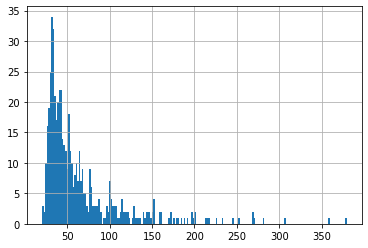

In [88]:
_ = simulated_vot_values[simulated_vot_values['WTP CAR time'] != 0]['WTP CAR time'].hist(bins=200)

Public transportation

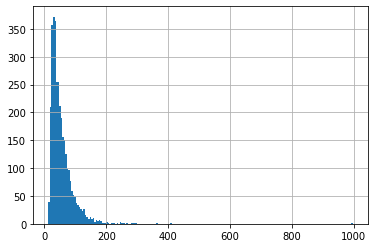

In [89]:
_ = simulated_vot_values[simulated_vot_values['WTP PT time'] != 0]['WTP PT time'].hist(bins=200)

In [90]:
avg_vot_pt = (
    simulated_vot_values['WTP PT time'] * 
    simulated_vot_values['weights']
).sum() / simulated_vot_values['weights'].sum()
print(f'Average value of time for PT: {avg_vot_pt:.3g} CHF/hour')

Average value of time for PT: 38 CHF/hour


In [91]:
avg_vot_car = (
    simulated_vot_values['WTP CAR time'] * 
    simulated_vot_values['weights']
).sum() / simulated_vot_values['weights'].sum()
print(f'Average value of time for car: {avg_vot_car:.3g} CHF/hour')

Average value of time for car: 7.14 CHF/hour


# Question 5 : Direct and cross aggregate elasticities of car cost and public transport cost

In [101]:
 #Choice proba:
prob_WALK = models.nested(V_pref, av, nest_pref, 1)
prob_CYCLE = models.nested(V_pref, av, nest_pref, 2)
prob_PT = models.nested(V_pref, av, nest_pref, 3)
prob_DRIVE = models.nested(V_pref, av, nest_pref, 4)


In [102]:
#Direct point elasticity of car cost
direct_elas_drive_cost= (Derive(prob_DRIVE,'cost_drive')*cost_drive/prob_DRIVE) #demander cost_drive=cost_driving_fuel+cost_driving_ccharge ?
#Direct point elasticity of public transportation cost 
direct_elas_pt_cost=(Derive(prob_PT,'cost_transit')*cost_pt/prob_PT)
#Cross point elasticity
cross_elas_Pdrive_Dpt=(Derive(prob_DRIVE,'cost_transit')*cost_pt/prob_DRIVE)
cross_elas_Ppt_Ddrive=(Derive(prob_DRIVE,'cost_drive')*cost_drive/prob_PT)


In [103]:
#Simulate
simulate_elast={
    'weights': weights,
    'Prob DRIVE': prob_DRIVE,
    'Prob PT': prob_PT,
    'direct_elas_drive_cost':direct_elas_drive_cost,
    'direct_elas_pt_cost':direct_elas_pt_cost,
    'cross_elas_Pdrive_Dpt':cross_elas_Pdrive_Dpt,
    'cross_elas_Ppt_Ddrive':cross_elas_Ppt_Ddrive,
}

In [104]:
biosim = bio.BIOGEME(database, simulate_elast)
simulated_values_elast = biosim.simulate(result_pref.getBetaValues())   

In [105]:
simulated_values_elast.iloc[0]

weights                   0.850773
Prob DRIVE                0.446493
Prob PT                   0.412685
direct_elas_drive_cost   -0.035108
direct_elas_pt_cost       0.000000
cross_elas_Pdrive_Dpt     0.000000
cross_elas_Ppt_Ddrive    -0.037984
Name: 0, dtype: float64

In [106]:
#Aggregations numerator/denominator
simulated_values_elast['denominator_pt'] = (
    simulated_values_elast['weights'] *
    simulated_values_elast['Prob PT']
)
simulated_values_elast['denominator_drive'] = (
    simulated_values_elast['weights'] *
    simulated_values_elast['Prob DRIVE']
)
#direct
simulated_values_elast['numerator_pt_dir']=(
    simulated_values_elast['weights'] *
    simulated_values_elast['Prob PT']*
    simulated_values_elast['direct_elas_pt_cost']
)
simulated_values_elast['numerator_drive_dir']=(
    simulated_values_elast['weights'] *
    simulated_values_elast['Prob DRIVE']*
    simulated_values_elast['direct_elas_drive_cost'])
#cross
simulated_values_elast['numerator_Pdrive_Dpt']=(
    simulated_values_elast['weights'] *
    simulated_values_elast['Prob DRIVE']*
    simulated_values_elast['cross_elas_Pdrive_Dpt']
)
simulated_values_elast['numerator_Ppt_Ddrive']=(
    simulated_values_elast['weights'] *
    simulated_values_elast['Prob PT']*
    simulated_values_elast['cross_elas_Ppt_Ddrive']
)

In [107]:
#Aggregation
agg_direct_elas_pt_cost=simulated_values_elast['numerator_pt_dir'].sum()/simulated_values_elast['denominator_pt'].sum()
agg_direct_elas_drive_cost=simulated_values_elast['numerator_drive_dir'].sum()/simulated_values_elast['denominator_drive'].sum()
agg_cross_elas_Pdrive_Dpt=simulated_values_elast['numerator_Pdrive_Dpt'].sum()/simulated_values_elast['denominator_drive'].sum()
agg_cross_elas_Ppt_Ddrive=simulated_values_elast['numerator_Ppt_Ddrive'].sum()/simulated_values_elast['denominator_pt'].sum()

In [108]:
print('denominator pt',simulated_values_elast['denominator_pt'].sum())
print('denominator drive',simulated_values_elast['denominator_drive'].sum())
print('agg_direct_elas_pt_cost',agg_direct_elas_pt_cost)
print('agg_direct_elas_drive_cost',agg_direct_elas_drive_cost)
print('agg_cross_elas_Pdrive_Dpt',agg_cross_elas_Pdrive_Dpt)
print('agg_cross_elas_Ppt_Ddrive',agg_cross_elas_Ppt_Ddrive)

denominator pt 1783.0685243095445
denominator drive 2205.0167917062
agg_direct_elas_pt_cost -0.07921337335187141
agg_direct_elas_drive_cost -0.0645095354499446
agg_cross_elas_Pdrive_Dpt 0.05438424894762127
agg_cross_elas_Ppt_Ddrive -0.07977517798839247


<AxesSubplot:>

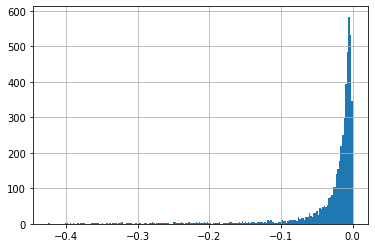

In [109]:
simulated_values_elast['numerator_Ppt_Ddrive'].hist(bins=200)